In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime

%matplotlib inline

In [49]:
# Pre-declare the data columns
data_columns = ['tracker_id', 'dB', 'year', 'month', 'day', 'hour', 'minute', 'second', 'distance']

In [50]:
# Function to convert the data's date columns into a single datetime object.
def to_datetime(x):
    """
    Parameters
    ==========
    - x     : a row in the dataframe of data.
    
    Returns
    =======
    - datetime version of the date.
    """
    return datetime(x['year'], x['month'], x['day'], x['hour'], x['minute'], x['second'])

def read_data(handle):
    """
    Parameters
    ==========
    - handle    : path to the data
    
    Returns
    =======
    - df        : pandas dataframe
    """
    df = pd.read_csv(handle)
    # df.columns = data_columns
    df['date'] = df.apply(lambda x:to_datetime(x), axis=1)
    df.set_index('date', inplace=True)
    
    return df

In [51]:
# Read in the data, set the date
southern = read_data('southern_pi.csv')
origin = read_data('origin_pi.csv')
eastern = read_data('eastern_pi.csv')

In [93]:
origin.dropna().head()

,tracker_id,dB,year,month,day,hour,minute,second,distance
date,,,,,,,,,
2015-12-21 14:42:06,68:9E:19:11:A6:DB,-68,2015,12,21,14,42,6,0
2015-12-21 14:42:16,68:9E:19:11:A6:DB,-65,2015,12,21,14,42,16,0
2015-12-21 14:42:26,68:9E:19:11:A6:DB,-71,2015,12,21,14,42,26,0
2015-12-21 14:42:36,68:9E:19:11:A6:DB,-63,2015,12,21,14,42,36,0
2015-12-21 14:42:47,68:9E:19:11:A6:DB,-68,2015,12,21,14,42,47,0


# Experiment Details

I will first analyze the data where each of the Pis were placed at origin.

This experiment's data was collected at 2:42 pm, and ended at 3:21 pm.

In this experiment, Nichola and Jon moved from 0 ft to 48 ft away from origin.

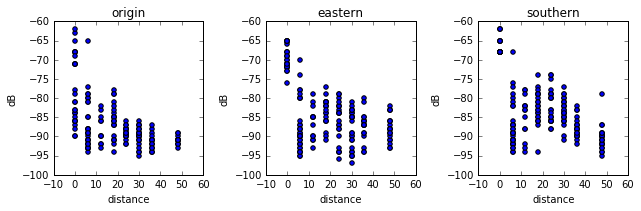

In [71]:
# Let's plot the data for each of the devices, from each of the base stations.

dfs = [(origin, 'origin'), (eastern, 'eastern'), (southern, 'southern')]

def plot_signal_vs_distance(device):
    fig = plt.figure(figsize=(9,3))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    axes = [ax1, ax2, ax3]
    for i, (df, title) in enumerate(dfs):
        df.dropna().query('tracker_id=="{0}"'.format(device)).plot(x='distance', y='dB', kind='scatter', ax=axes[i])
        axes[i].set_title(title)
    plt.tight_layout()

device = '68:9E:19:11:A6:DB'
plot_signal_vs_distance(device)

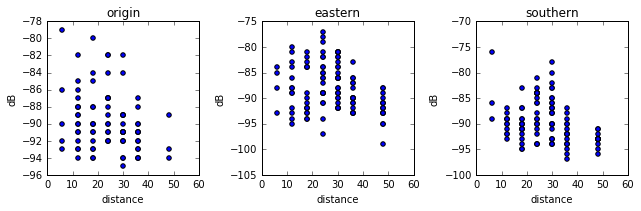

In [73]:
device = 'F4:B8:5E:C4:56:22'
plot_signal_vs_distance(device)

## Preliminary Conclusions

As we can see here, the data for device `68:9E:19:11:A6:DB` was much better than the device `F4:B8:5E:C4:56:22`. There seems to be a stronger correlation with distance on device `68` than device `F4`. I will attempt Bayesian modelling to quantify the uncertainty around each distance measurement for device `68`.

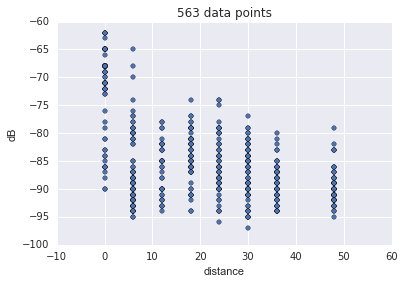

In [160]:
# In order to have more data put together, I will concatenate the 3 data frames.
device = '68:9E:19:11:A6:DB'
# device = 'F4:B8:5E:C4:56:22'

all_data = origin.dropna().append(eastern.dropna()).append(southern.dropna()).query('tracker_id=="{0}"'.format(device))
all_data.plot(x='distance', y='dB', kind='scatter', title='{0} data points'.format(len(all_data)))

/Users/ericmjl/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


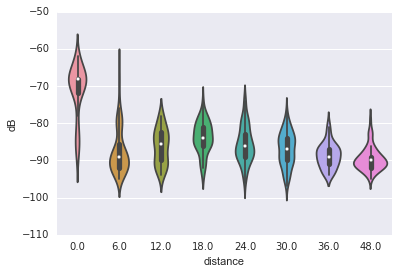

In [161]:
sns.violinplot(x=all_data['distance'], y=all_data['dB'])

Looking at the distribution of data points, it looks like it will be difficult for us to resolve distances less than 24 ft.

I think a second experiment is in order.

In [181]:
import pymc3 as pm

with pm.Model() as model:
    # Hyperparameters for A and B
    # mu_a = pm.Normal('mu_A', mu=0, sd=10)
    # sig_a = pm.Uniform('sigma_A', lower=0, upper=10)
    
    # mu_b = pm.Normal('mu_B', mu=0, sd=10)
    # sig_b = pm.Uniform('sigma_B', lower=0, upper=10)
    
    # Estimate the intercepts
    A = pm.Normal('A', mu=-0.2, sd=3)
    B = pm.Normal('B', mu=-50, sd=3)
    
    # Error term
    err = pm.Normal('error', mu=-30, sd=10)
    
    # Model prediction:
    dB = A * all_data['distance'] + B + err
    
    # dB likelihood
    db_like = pm.Normal('dB', mu=dB, sd=10, observed=all_data['dB'])

In [182]:
with model:
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(10000, step)

 [-----------------100%-----------------] 10000 of 10000 complete in 40.7 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13950e860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13975f470>]], dtype=object)

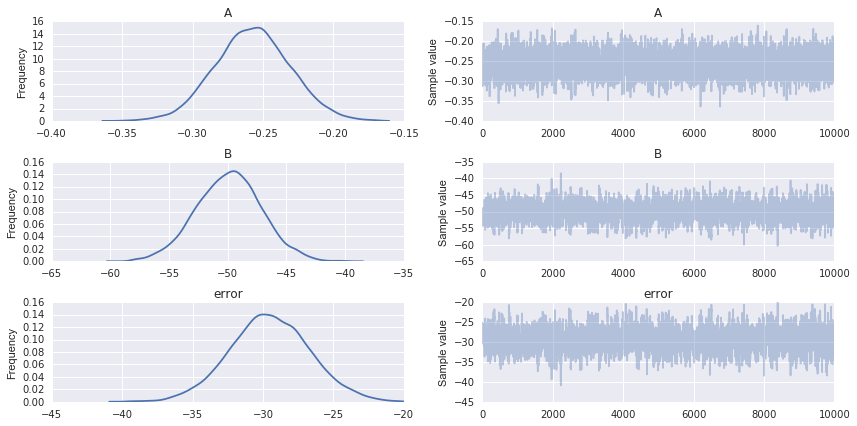

In [183]:
pm.traceplot(trace)

In [184]:
pm.summary(trace)


A:
 
  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.257           0.027            0.000            [-0.309, -0.205]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.309         -0.275         -0.257         -0.240         -0.204


B:
 
  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -49.898          2.780            0.071            [-55.325, -44.295]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -55.449        -51.772        -49.835        -48.043        -44.328


error:
 
  Mean             SD               MC Error         95% HPD interval
  ---------------------